# Predicting total bases a player is expected from a starting pitcher

Data provided by <a href="https://www.sports-reference.com/sharing.html?utm_source=direct&utm_medium=Share&utm_campaign=ShareTool">Baseball-Reference.com</a>: <a href="https://www.baseball-reference.com/players/gl.fcgi?id=alonspe01&t=b&year=2022&utm_source=direct&utm_medium=Share&utm_campaign=ShareTool#batting_gamelogs">View Original Table</a><br>Generated 8/8/2023.

In [114]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import validators
from validators import ValidationFailure
import pandas as pd
import numpy as np

In [18]:
def get_name():
    name = input("pitcher name 5 letters last name two letters first name: ")
    return name

In [19]:
# get the throwing hand of the pitcher
def get_hand():
    if "Left" in str(soup.findAll('p')[1])[40:]:
        hand = 0
    else:
        hand = 1
    return hand

In [125]:
def get_column_names(soup):
    soup.findAll('tr', limit=2)
    if len(soup.findAll('tr', limit=2)) == 0:
        return None
    else:
        # use getText()to extract the text we need into a list
        headers = [th.getText() for th in soup.findAll('tr', limit=2)[0].findAll('th')]
        # exclude the first column as we will not need the ranking order from Basketball Reference for the analysis
        headers = headers[1:]
        headers
        return headers

In [50]:
def get_data(soup, headers):
    # avoid the first header row
    rows = soup.findAll('tr')[1:]
    player_stats = [[td.getText() for td in rows[i].findAll('td')]
                for i in range(len(rows))]   
    stats = pd.DataFrame(player_stats, columns = headers)
    return stats

In [22]:
def remove_bad_rows(stats, rows):
    remove = []
    for i in range(rows):
        if str(stats.loc[i]['Gcar']) == 'None' or stats.loc[i]['Gcar'] == '':
            remove.append(i)
    stats = stats.drop(remove)
    return stats

In [139]:
def get_pitcher(name):
    # 2021 season
    pitcher_name = name
    # URL page we will scraping (see image above)
    # url = "https://www.baseball-reference.com/players/gl.fcgi?id={}01&t=p&year=2021".format(pitcher_name)
    url = input("Game log year 2022: ")
    url2 = url
    url = url[:len(url) - 1] + '1'
    print(url, url2)
    # this is the HTML from the given URL
    html = urlopen(url)
    soup = BeautifulSoup(html)

    hand = get_hand(soup)

    headers = get_column_names(soup)
    if headers == None:
        html = urlopen(url2)
        soup = BeautifulSoup(html)
        headers = get_column_names(soup)
        stats2 = get_data(soup, headers)
        stats2 = remove_bad_rows(stats2, stats2.shape[0])
        if hand == 0:
            stats2["Hand"] = np.zeros(stats2.shape[0])
        else:
            stats2["Hand"] = np.ones(stats2.shape[0]) 
        return stats2
    else:    
        stats = get_data(soup, headers)    
        stats = remove_bad_rows(stats, stats.shape[0])

    # 2022 season
    # URL page we will scraping (see image above)
    # url = "https://www.baseball-reference.com/players/gl.fcgi?id={}01&t=p&year=2022".format(pitcher_name)

    # this is the HTML from the given URL

    html = urlopen(url2)
    soup = BeautifulSoup(html)

    stats2 = get_data(soup, headers)
    stats2 = remove_bad_rows(stats2, stats2.shape[0])
    stats = stats.append(stats2, ignore_index=True)
    if hand == 0:
        stats["Hand"] = np.zeros(stats.shape[0])
    else:
        stats["Hand"] = np.ones(stats.shape[0])   
    return stats

In [265]:
# this function drops rows we don't care about and averages out the last 20 games the pitcher has started
def get_pitcher_avg(name, game_num):
    space = name.index(' ')
    if len(name[space+1:]) < 5:
        search_name = name[space+1:]
    else:
        search_name = name[space+1:space+6]
    search_name += name[0:2]
    search_name = search_name.lower()
    df = get_pitcher(search_name)
    remove = []
#    for i in range(len(df)):
#        if str(df.loc[i]['IP']) == '0.0':
#            remove.append(i)
#    df = df.drop(remove)
    df = df.drop(['Gtm', 'Date', 'Tm', '', 'Opp', 'Rslt', 'Inngs',
       'Dec', 'DR', 'IP', 'R', 'ER', 'BB', 'SO', 'HBP', 'ERA', 'BF', 'Pit', 'Str', 'StL', 'StS', 'GB', 'FB', 'LD', 'PU', 'Unk',
       'GSc', 'IR', 'IS', 'SB', 'CS', 'PO', 'AB', 'IBB', 'GDP',
       'SF', 'ROE', 'aLI', 'WPA', 'acLI', 'cWPA', 'RE24', 'DFS(DK)', 'DFS(FD)',
       'Entered', 'Exited'], axis = 1)
    
    df['Gcar'] = df['Gcar'].astype(int)
    df['P_H'] = df['H'].astype(int)
    df['P_HR'] = df['HR'].astype(int)
    df['P_FIP'] = df['FIP'].astype(float)
    df['P_2B'] = df['2B'].astype(int)
    df['P_3B'] = df['3B'].astype(int)
    df = df.drop(['H', 'HR', 'FIP', '2B', '3B'], axis = 1)
    if game_num > 20:
        avg = df.loc[(df['Gcar'] < game_num) & (df['Gcar'] > game_num - 21)].mean()
    else:
        avg = df.loc[(df['Gcar'] < game_num)].mean()
             
    avg = avg.drop(['Gcar'])
    avg["Name"] = name
    avg["Career Game Number"] = game_num
    avg["Hand"] = int(avg["Hand"])
    return avg

In [25]:
def add_pitcher (pitcher_name, game_num):
    avg = get_pitcher_avg(pitcher_name, game_num)
    pitcher = pd.DataFrame(avg).T
    return pitcher


In [70]:
# beginning of data frame
pitcher_against_mets_2022 = pd.DataFrame(add_pitcher("Patrick Corbin", 248))

Game log year 2022: https://www.baseball-reference.com/players/gl.fcgi?id=corbipa01&t=p&year=2022
https://www.baseball-reference.com/players/gl.fcgi?id=corbipa01&t=p&year=2021 https://www.baseball-reference.com/players/gl.fcgi?id=corbipa01&t=p&year=2022


In [285]:
# add each starting pitcher skipping games Pete Alonso didn't play, and pitchers debuts
pitcher_against_mets_2022 = pitcher_against_mets_2022.append(add_pitcher("Paolo Espiono", 91), ignore_index=True)
pitcher_against_mets_2022.tail(10)

Game log year 2022: https://www.baseball-reference.com/players/gl.fcgi?id=espinpa01&t=p&year=2022
https://www.baseball-reference.com/players/gl.fcgi?id=espinpa01&t=p&year=2021 https://www.baseball-reference.com/players/gl.fcgi?id=espinpa01&t=p&year=2022


,Hand,P_H,P_HR,P_FIP,P_2B,P_3B,Name,Career Game Number
149,0,5.55,0.85,4.0385,1.1,0.15,Cole Irvin,79
150,0,5.25,0.75,4.63,2.25,0.25,Ken Waldichuk,5
151,0,3.8,0.533333,3.159333,0.666667,0.066667,JP Sears,16
152,1,5.35,0.75,3.578,1.35,0.2,Pablo Lopez,93
153,0,4.1,0.55,3.281,1.05,0.1,Jesus Luzardo,60
154,0,5.1,0.4,2.625,0.75,0.1,Max Fried,125
155,1,5.55,0.8,3.308,0.8,0.0,Kyle Wright,51
156,1,4.4,1.0,4.0985,0.75,0.05,Charlie Morton,323
157,1,2.7,0.85,6.2615,0.65,0.0,Cory Abbott,23
158,1,4.95,0.95,4.4675,0.7,0.05,Paolo Espiono,91


In [291]:
pitcher_against_mets_2022.to_csv("pitchers_against_mets.csv", index = False)

In [292]:
test = pd.read_csv("pitchers_against_mets.csv")

In [293]:
test.head()

,Hand,P_H,P_HR,P_FIP,P_2B,P_3B,Name,Career Game Number
0,0,6.35,1.250000,5.362500,1.050000,0.150000,Patrick Corbin,248
1,1,4.50,1.357143,6.971429,0.714286,0.142857,Josiah Gray,15
2,1,6.00,1.000000,4.480000,0.000000,0.000000,Joan Adon,2
3,1,5.45,0.900000,4.520000,1.050000,0.050000,Erick Fedde,76
4,0,2.95,0.100000,3.169500,0.300000,0.050000,Ranger Suarez,84


In [342]:
pete_alonso = pd.read_csv("pete_alonso.csv")

In [297]:
pete_alonso.columns

Index(['Rk', 'Gcar', 'Gtm', 'Date', 'Tm', 'Unnamed: 5', 'Opp', 'Rslt', 'Inngs',
       'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'IBB', 'SO', 'HBP',
       'SH', 'SF', 'ROE', 'GDP', 'SB', 'CS', 'BA', 'OBP', 'SLG', 'OPS', 'BOP',
       'aLI', 'WPA', 'acLI', 'cWPA', 'RE24', 'DFS(DK)', 'DFS(FD)', 'Pos'],
      dtype='object')

In [343]:
pete_alonso['TB'] = pete_alonso['HR'] * 4 + pete_alonso['3B'] * 3 + pete_alonso['2B'] * 2 + (pete_alonso['H'] - pete_alonso['HR'] - pete_alonso['3B'] - pete_alonso['2B'])

In [348]:
pitcher_against_mets_2022['Pete Alonso TB'] = pete_alonso['TB']

In [351]:
pitcher_against_mets_2022.head()

,Hand,P_H,P_HR,P_FIP,P_2B,P_3B,Name,Career Game Number,Pete Alonso TB
0,0,6.35,1.25,5.3625,1.05,0.15,Patrick Corbin,248,2
1,1,4.5,1.357143,6.971429,0.714286,0.142857,Josiah Gray,15,2
2,1,6.0,1.0,4.48,0.0,0.0,Joan Adon,2,4
3,1,5.45,0.9,4.52,1.05,0.05,Erick Fedde,76,0
4,0,2.95,0.1,3.1695,0.3,0.05,Ranger Suarez,84,0


I just combined Pete's total base count to the actual pitcher and their stats. Now we will build the model.

In [353]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import SGDRegressor

from sklearn.model_selection import train_test_split

In [354]:
# Feature selection
features = ['Hand', 'P_H', 'P_HR', 'P_FIP', 'P_2B', 'P_3B']

In [355]:
pitcher_against_mets_2022.isna().sum() # Check for missing values

Hand                  0
P_H                   0
P_HR                  0
P_FIP                 0
P_2B                  0
P_3B                  0
Name                  0
Career Game Number    0
Pete Alonso TB        0
dtype: int64

In [356]:
target = pitcher_against_mets_2022['Pete Alonso TB']
target.head()

0    2
1    2
2    4
3    0
4    0
Name: Pete Alonso TB, dtype: int64

In [357]:
X = pitcher_against_mets_2022[features]
y = target

In [358]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [364]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [375]:
SGD = SGDRegressor(eta0=0.001)
SGD.fit(X_train, y_train)

y_preds = SGD.predict(X_test)

In [376]:
# Evaluation
y_preds

array([2.71387408, 1.92073774, 1.75585151, 1.57889716, 1.77482958,
       1.14925123, 1.69285714, 1.3958007 , 1.57479564, 1.84375771,
       1.89239655, 1.73102146, 1.4583914 , 1.88101448, 1.65772726,
       2.3560422 , 2.3649455 , 2.47157589, 1.77162162, 2.03634672,
       1.44544464, 0.82466632, 1.29499009, 1.48289268, 1.65506891,
       2.18784289, 1.80960625, 1.89209648, 1.34892486, 1.94620928,
       1.49577546, 1.80602275])

In [372]:
np.array(y_test)

array([0, 1, 1, 1, 4, 9, 4, 0, 3, 4, 1, 2, 0, 2, 2, 1, 1, 4, 0, 1, 9, 0,
       3, 4, 5, 1, 4, 0, 0, 4, 2, 0])

In [380]:
SGD.score(X_test, y_test)

-0.1495443846433251

In [381]:
# Different model
from sklearn.ensemble import GradientBoostingRegressor
GB = GradientBoostingRegressor()
GB.fit(X_train, y_train)

y_preds = GB.predict(X_test)


In [382]:
mean_absolute_error(y_test, y_preds)

1.9055678162169807

In [384]:
GB.score(X_test, y_test)

-0.1793042929944617

In [397]:
len(y_test)

32

In [427]:
predicted_correctly_over = []
for i in range(32):
    predicted_correctly_over.append(y_preds[i] > 2 and np.array(y_test)[i] > 1.5)


predicted_correctly_under = []
for i in range(32):
    predicted_correctly_under.append(y_preds[i] < 1 and np.array(y_test)[i] < 1.5)

predicted_incorrectly_over = []
for i in range(32):
    predicted_incorrectly_over.append(y_preds[i] > 2 and np.array(y_test)[i] < 1.5)

    
predicted_incorrectly_under = []
for i in range(32):
    predicted_incorrectly_under.append(y_preds[i] < 2 and np.array(y_test)[i] > 1.5)


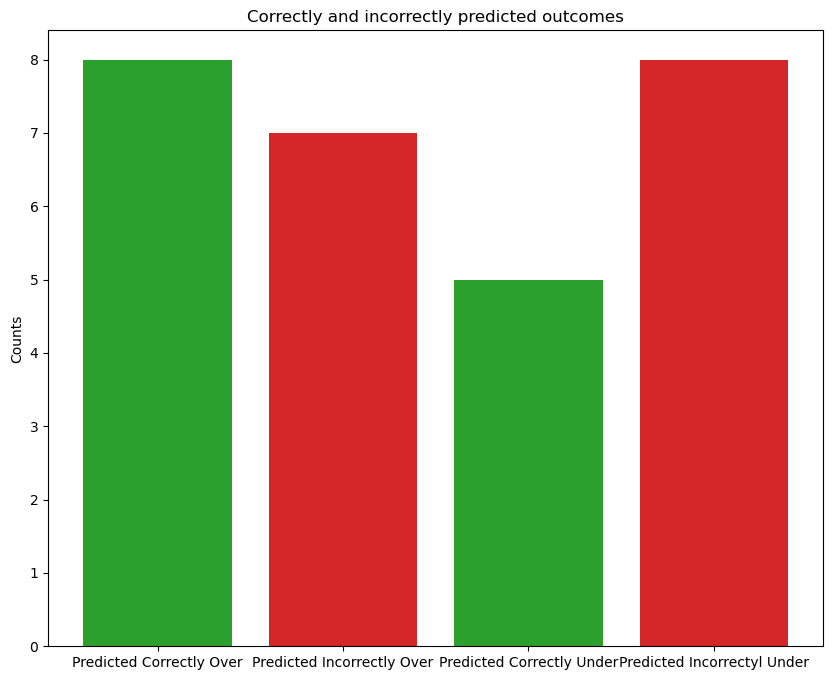

In [440]:
fig, ax = plt.subplots(figsize = (10, 8))

bars = ['Predicted Correctly Over', 'Predicted Incorrectly Over', 'Predicted Correctly Under', 'Predicted Incorrectly Under']
counts = [np.array(predicted_correctly_over).sum(), 
          np.array(predicted_incorrectly_over).sum(), 
          np.array(predicted_correctly_under).sum(),
         np.array(predicted_incorrectly_under).sum()]
bar_colors = ['tab:green', 'tab:red', 'tab:green', 'tab:red']

ax.bar(bars, counts, color=bar_colors)hgyt

ax.set_ylabel('Counts')
ax.set_title('Correctly and incorrectly predicted outcomes')

plt.show()